# DATA PREPARATION

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Parameters" data-toc-modified-id="1-Parameters-1">1 Parameters</a></span></li><li><span><a href="#2-Import" data-toc-modified-id="2-Import-2">2 Import</a></span><ul class="toc-item"><li><span><a href="#2.1-Libraries" data-toc-modified-id="2.1-Libraries-2.1">2.1 Libraries</a></span></li><li><span><a href="#2.2-Files" data-toc-modified-id="2.2-Files-2.2">2.2 Files</a></span></li></ul></li><li><span><a href="#3-Cleaning" data-toc-modified-id="3-Cleaning-3">3 Cleaning</a></span></li><li><span><a href="#4-Filtering-&amp;-Pivoting" data-toc-modified-id="4-Filtering-&amp;-Pivoting-4">4 Filtering &amp; Pivoting</a></span></li><li><span><a href="#5-Nelson-Siegel" data-toc-modified-id="5-Nelson-Siegel-5">5 Nelson Siegel</a></span></li><li><span><a href="#6-Visualization" data-toc-modified-id="6-Visualization-6">6 Visualization</a></span><ul class="toc-item"><li><span><a href="#6.1-Level-&amp;-Spreads" data-toc-modified-id="6.1-Level-&amp;-Spreads-6.1">6.1 Level &amp; Spreads</a></span></li><li><span><a href="#6.2-Volatility" data-toc-modified-id="6.2-Volatility-6.2">6.2 Volatility</a></span></li><li><span><a href="#6.3-Correlation" data-toc-modified-id="6.3-Correlation-6.3">6.3 Correlation</a></span></li><li><span><a href="#6.4-Nelson-Siegel" data-toc-modified-id="6.4-Nelson-Siegel-6.4">6.4 Nelson Siegel</a></span></li></ul></li><li><span><a href="#7-Extraction" data-toc-modified-id="7-Extraction-7">7 Extraction</a></span></li></ul></div>

### 1 Parameters
***

In [1]:
start_date = "01-01-2005"
end_date = "30-06-2020"

freq_all = ["day","week"]
freq = freq_all[0]

tenors_list = [0.25, 0.5, 1, 2, 3 , 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

In [2]:
# Settings
print (f'- Yield data from {start_date} to {end_date} is being considered.')
print (f'- Yield curve data frequency is {freq}-wise.')
print (f'- Relevant tenors range from {tenors_list[0]} to {tenors_list[-1]} years.')

- Yield data from 01-01-2005 to 30-06-2020 is being considered.
- Yield curve data frequency is day-wise.
- Relevant tenors range from 0.25 to 30 years.


### 2 Import
***

#### 2.1 Libraries

In [3]:
# Scaling
from sklearn.preprocessing import StandardScaler

# Data handling
import datetime as dt
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%config InlineBackend.figure_format ="retina"

# Other
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### 2.2 Files

In [4]:
filepath_in  = "../assets/files/01-input/"
filepath_out = "../assets/files/02-clean/"
filename     = "data.csv"

data_raw = pd.read_csv (filepath_in+filename)

In [5]:
print ("Data Matrix X:")
print (f'- Row: Observations n = {data_raw.shape[0]:,.0f}')
print (f'- Col: Criteria c = {data_raw.shape[1]}')

Data Matrix X:
- Row: Observations n = 4,240,323
- Col: Criteria c = 40


### 3 Cleaning
***

In [6]:
# Croping the time frame
data_raw["TIME_PERIOD"] = pd.to_datetime(data_raw["TIME_PERIOD"], format="%Y-%m-%d")
data_raw = data_raw[(data_raw["TIME_PERIOD"]>=start_date) & 
                    (data_raw["TIME_PERIOD"]<=end_date)]

In [7]:
data = data_raw.copy()

# Remove data on SRS (spot rate spread)
data["DATA_TYPE_FM"] = data["DATA_TYPE_FM"].apply(lambda x: "SRS" if x[:3] == "SRS" else x)
data = data[data["DATA_TYPE_FM"] != "SRS"]
data[["TYPE","MATURITY"]] = data["DATA_TYPE_FM"].str.split(pat = "_", expand = True)

# Keep only relevant columns
data = data[["TYPE", "MATURITY", "UNIT", "TIME_PERIOD", "OBS_VALUE"]]

In [8]:
display (data.head())

print ("Data Matrix X:")
print (f'- Row: Observations n = {data.shape[0]:,.0f}')
print (f'- Col: Criteria c = {data.shape[1]}')

,TYPE,MATURITY,UNIT,TIME_PERIOD,OBS_VALUE
85,BETA0,None,PURE_NUMB,2005-01-03,4.961704
86,BETA0,None,PURE_NUMB,2005-01-04,4.909715
87,BETA0,None,PURE_NUMB,2005-01-05,4.913796
88,BETA0,None,PURE_NUMB,2005-01-06,4.845211
89,BETA0,None,PURE_NUMB,2005-01-07,4.814018


Data Matrix X:
- Row: Observations n = 4,138,560
- Col: Criteria c = 5


In [9]:
data_clean = data.copy()
data_clean = data_clean.reset_index(drop = True)


# Extract maturity year & month
data_clean[["MAT_YEAR","MAT_MONTH"]] = data_clean["MATURITY"].str.split(pat="Y",expand = True)

month = []
year = []

for index, value in data_clean["MAT_MONTH"].iteritems():
    if value == None:
        month.append(data_clean["MAT_YEAR"].loc[index])
        year.append(0)

    else:
        month.append(value)
        year.append(data_clean["MAT_YEAR"].loc[index])


# Clean matury year & month columns
data_clean["MAT_MONTH"] = pd.Series(month)
data_clean["MAT_MONTH"] = data_clean["MAT_MONTH"].fillna("0")
data_clean["MAT_MONTH"] = data_clean["MAT_MONTH"].apply(lambda x: x[:-1] if x != None else x)
data_clean["MAT_MONTH"] = data_clean["MAT_MONTH"].apply(lambda x: 0 if x =="" else x)

data_clean["MAT_YEAR"] = pd.Series(year)
data_clean[["MAT_YEAR","MAT_MONTH"]] = data_clean[["MAT_YEAR","MAT_MONTH"]].apply(lambda x: pd.to_numeric(x))
data_clean["MAT_NUM"] = data_clean["MAT_YEAR"]+data_clean["MAT_MONTH"]/12


# Keep only relevant features
data_clean = data_clean.reset_index(drop = True)
data_clean = data_clean.rename(columns = {"MATURITY":"MAT_STR"})
data_clean = data_clean[["TYPE","TIME_PERIOD","MAT_STR","MAT_NUM","UNIT","OBS_VALUE"]]

In [10]:
display (data_clean.head())

print ("Data Matrix X:")
print (f'- Row: Observations n = {data_clean.shape[0]:,.0f}')
print (f'- Col: Criteria c = {data_clean.shape[1]}')

,TYPE,TIME_PERIOD,MAT_STR,MAT_NUM,UNIT,OBS_VALUE
0,BETA0,2005-01-03,None,0.0,PURE_NUMB,4.961704
1,BETA0,2005-01-04,None,0.0,PURE_NUMB,4.909715
2,BETA0,2005-01-05,None,0.0,PURE_NUMB,4.913796
3,BETA0,2005-01-06,None,0.0,PURE_NUMB,4.845211
4,BETA0,2005-01-07,None,0.0,PURE_NUMB,4.814018


Data Matrix X:
- Row: Observations n = 4,138,560
- Col: Criteria c = 6


### 4 Filtering & Pivoting
***

In [11]:
# Filter data for spot rates with selected maturities
spot = data_clean[(data_clean["TYPE"]=="SR") & 
                  (data_clean["MAT_NUM"].isin(tenors_list))]


# Create dataframe of tenors
tenors_df = pd.concat([pd.Series(spot["MAT_STR"].unique()), 
                       pd.Series(spot["MAT_NUM"].unique())], axis = 1)

tenors_df.columns = ["MAT_STR","MAT_NUM"]                      
tenors_df = tenors_df.sort_values(by="MAT_NUM", ascending =True)
tenors_df = tenors_df.reset_index(drop=True)


# Create series of tenors
tenors_str = tenors_df["MAT_STR"]
tenors_num = tenors_df["MAT_NUM"]

tenors_df.to_csv(filepath_out+"tenors.csv")
display (tenors_df)

,MAT_STR,MAT_NUM
0,3M,0.25
1,6M,0.50
2,1Y,1.00
3,2Y,2.00
4,3Y,3.00
5,4Y,4.00
6,5Y,5.00
7,6Y,6.00
8,7Y,7.00
9,8Y,8.00


In [12]:
# Pivot table by tenors
spot_clean = spot.copy()

spot_clean = spot_clean.sort_values(by="TIME_PERIOD", ascending = True)
spot_clean = spot_clean.pivot_table(columns=["MAT_NUM"],index=["TIME_PERIOD"],values=["OBS_VALUE"], aggfunc=np.sum)
spot_clean = pd.DataFrame(data = spot_clean.values, 
                          columns = tenors_str, 
                          index = spot["TIME_PERIOD"].unique())

spot_clean.columns.name = "End_of_day"
spot = spot_clean.copy()

In [13]:
spot["date"] = spot.index


# Filter data frame according to set frequency
if freq == "week":    
    spot["freq"] = spot["date"].dt.week
elif freq == "month": 
    spot["freq"] = spot["date"].dt.month
else:
    spot["freq"] = spot["date"].dt.day

    
spot["count"]  = np.where(spot["freq"].shift() != spot["freq"],1,0).cumsum()
spot = spot.groupby("count").last()

spot.index = spot["date"]
spot.index.name = None
spot.columns.name = "End_of_"+str(freq)
spot = spot.drop(["freq","date"], axis = 1) 

In [14]:
display (spot.head())

print (f'End-of-{freq} yields per tenor:')
print (f'- Row: Observations n = {spot.shape[0]}')
print (f'- Col: Features f = {spot.shape[1]}')

End_of_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2005-01-03,2.109629,2.151024,2.239782,2.430961,2.626467,2.815842,2.993412,3.156521,3.304362,3.437220,3.555984,3.661840,3.839974,3.981507,4.094849,4.186626,4.261873,4.324361,4.376903,4.421599,4.460031,4.493401
2005-01-04,2.055906,2.115073,2.231982,2.457144,2.667102,2.859640,3.034202,3.191244,3.331801,3.457203,3.568896,3.668323,3.835797,3.969342,4.076773,4.164136,4.236022,4.295884,4.346320,4.389285,4.426264,4.458392
2005-01-05,2.064858,2.126695,2.248179,2.479969,2.694019,2.888871,3.064513,3.221795,3.362033,3.486758,3.597556,3.695968,3.861299,3.992777,4.098339,4.184064,4.254532,4.313175,4.362560,4.404618,4.440808,4.472248
2005-01-06,2.060515,2.107919,2.207488,2.415567,2.622265,2.818094,2.998407,3.161485,3.307315,3.436821,3.551382,3.652554,3.820866,3.952938,4.057725,4.142005,4.210780,4.267707,4.315469,4.356040,4.390893,4.421138
2005-01-07,2.048016,2.092720,2.187889,2.390159,2.593648,2.787782,2.967263,3.129985,3.275709,3.405230,3.519858,3.621110,3.789565,3.921729,4.026567,4.110870,4.179653,4.236581,4.284340,4.324908,4.359757,4.389998


End-of-day yields per tenor:
- Row: Observations n = 3832
- Col: Features f = 22


### 5 Nelson Siegel
***

In [15]:
factors = ["BETA0","BETA1","BETA2","BETA3","TAU1","TAU2"]

In [16]:
# Filter for factors
nelson_siegel = data_clean[["TYPE","TIME_PERIOD","OBS_VALUE"]][(data_clean["TYPE"].isin(factors))]
nelson_siegel = nelson_siegel.sort_values(by="TIME_PERIOD", ascending = True)
nelson_siegel = nelson_siegel.pivot_table(columns=["TYPE"],index=["TIME_PERIOD"],values=["OBS_VALUE"], aggfunc=np.sum)

nelson_siegel.columns = nelson_siegel.columns.get_level_values(1)
nelson_siegel.index.name = None
nelson_siegel.head()

TYPE,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
2005-01-03,4.961704,-2.890864,-0.111447,-1.415937,3.395999,2.723281
2005-01-04,4.909715,-2.913265,-0.025017,-1.205345,3.337923,3.099315
2005-01-05,4.913796,-2.911350,0.009475,-1.171742,3.317917,3.090908
2005-01-06,4.845211,-2.829891,0.017249,-1.295412,3.335752,2.579415
2005-01-07,4.814018,-2.808103,0.009410,-1.320543,3.342847,2.549312


In [17]:
# Filter for frequency
nelson_siegel["date"] = nelson_siegel.index

if freq == "week":
    nelson_siegel["freq"] = nelson_siegel["date"].dt.week
elif freq == "month":
    nelson_siegel["freq"] = nelson_siegel["date"].dt.month
else:
    nelson_siegel["freq"] = nelson_siegel["date"].dt.day

    
nelson_siegel["count"]  = np.where(nelson_siegel["freq"].shift() != nelson_siegel["freq"],1,0).cumsum()
nelson_siegel = nelson_siegel.groupby("count").last()

nelson_siegel.index = nelson_siegel["date"]
nelson_siegel.index.name = None

nelson_siegel = nelson_siegel.drop(["freq","date"], axis = 1) 
nelson_siegel.head()

TYPE,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
2005-01-03,4.961704,-2.890864,-0.111447,-1.415937,3.395999,2.723281
2005-01-04,4.909715,-2.913265,-0.025017,-1.205345,3.337923,3.099315
2005-01-05,4.913796,-2.911350,0.009475,-1.171742,3.317917,3.090908
2005-01-06,4.845211,-2.829891,0.017249,-1.295412,3.335752,2.579415
2005-01-07,4.814018,-2.808103,0.009410,-1.320543,3.342847,2.549312


### 6 Visualization
***

#### 6.1 Level & Spreads

In [18]:
dates = ["2019-01-25", "2019-02-22", "2019-03-29", "2019-04-26"]
maturities = ["3M", "1Y", "5Y","10Y", "30Y"]

color = cm.rainbow(np.linspace(0,1,len(maturities)))

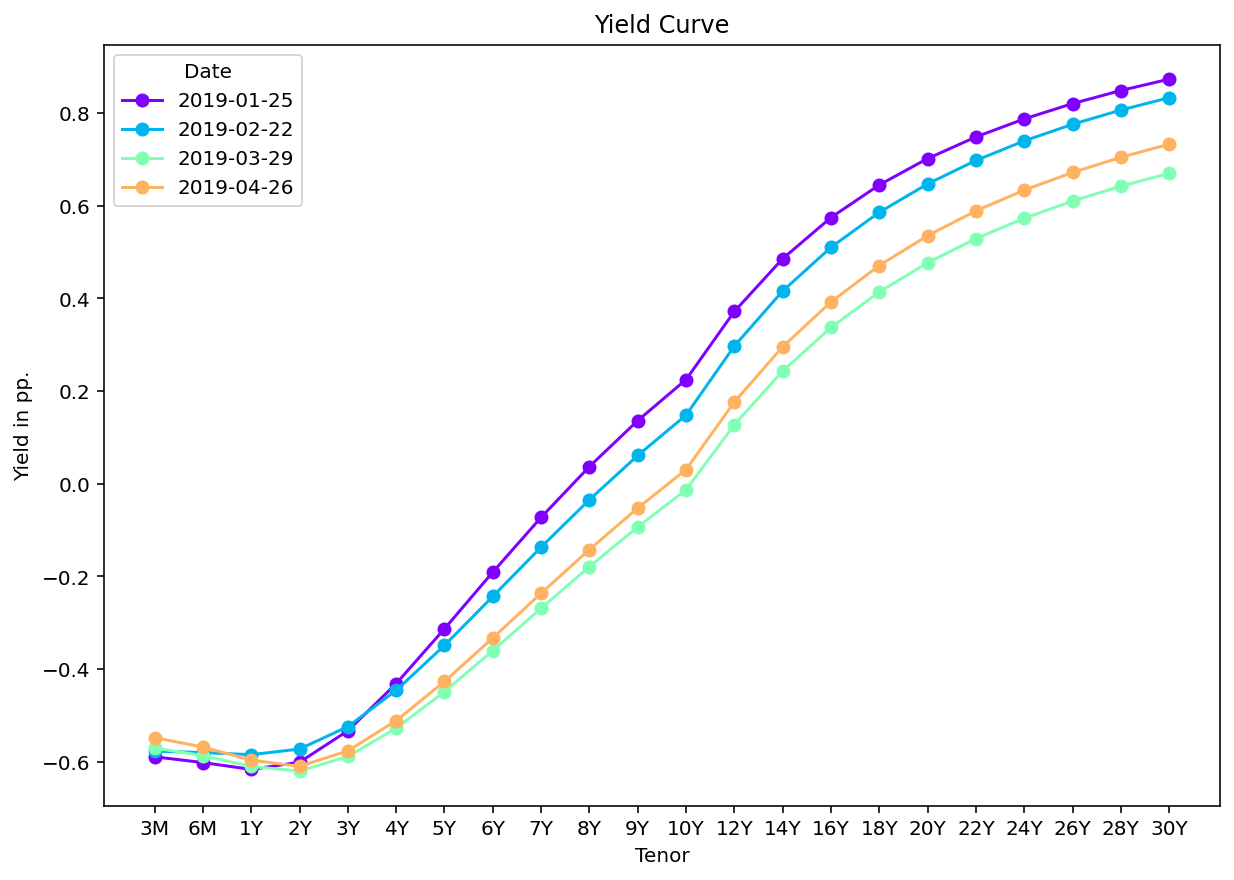

In [19]:
fig = plt.figure(figsize = [10,7])

for i,j in zip(dates, color):
    marker = plt.plot (spot.loc[i], "-bo", c = j, label = i)
    
plt.title ("Yield Curve")
plt.xlabel ("Tenor")
plt.ylabel ("Yield in pp.")
plt.legend(title = "Date")
plt.show()

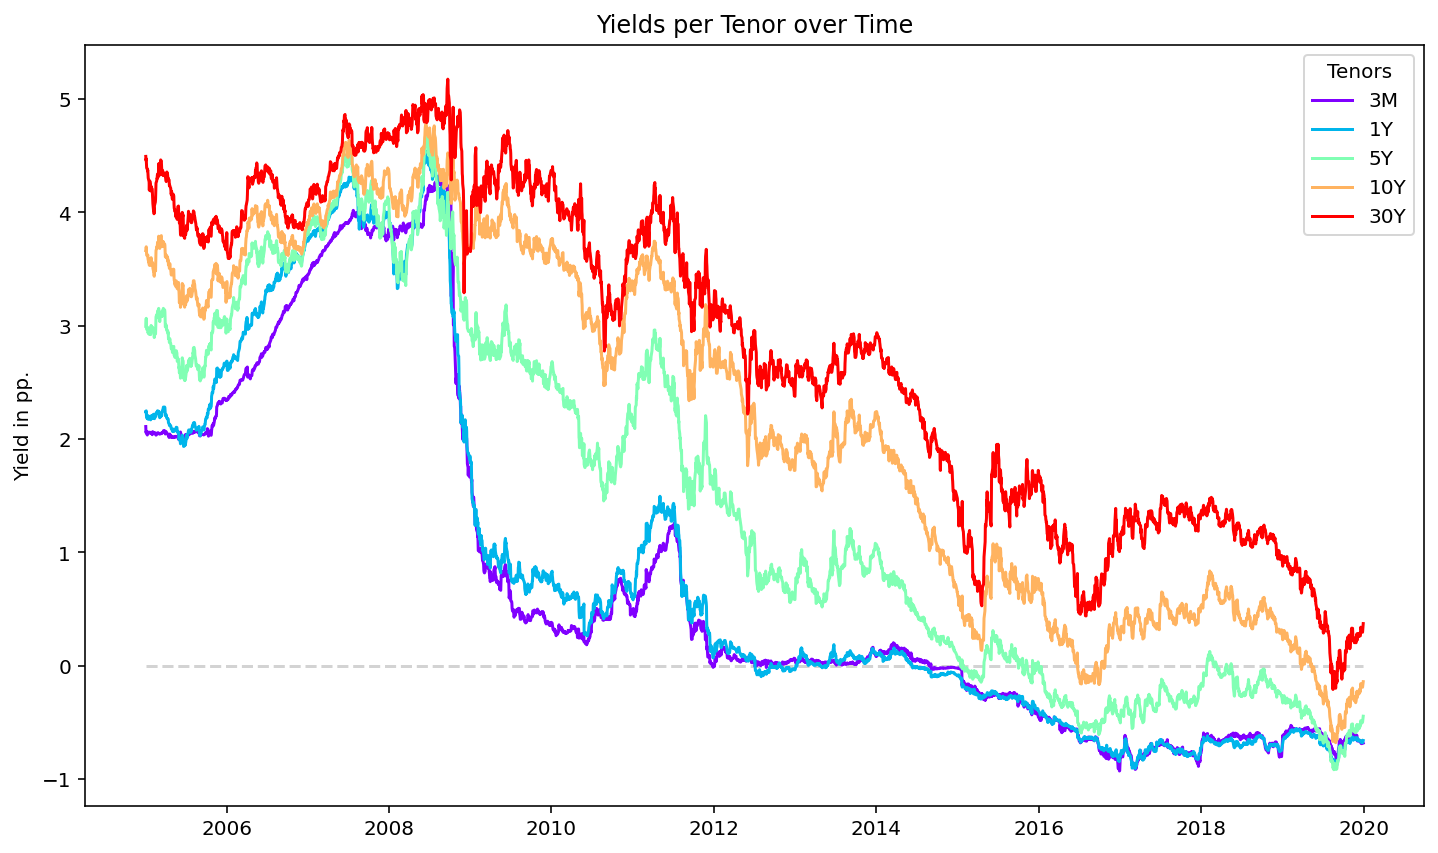

In [20]:
fig = plt.figure(figsize = [12,7])

for i,j in zip(maturities, color):
    plt.plot (spot[i], c = j, label = i)

plt.hlines(0, xmin=min(spot.index), xmax= max(spot.index), colors="lightgrey", linestyles="dashed")

plt.title ("Yields per Tenor over Time")
plt.ylabel ("Yield in pp.")

plt.legend(title = "Tenors")
plt.show()

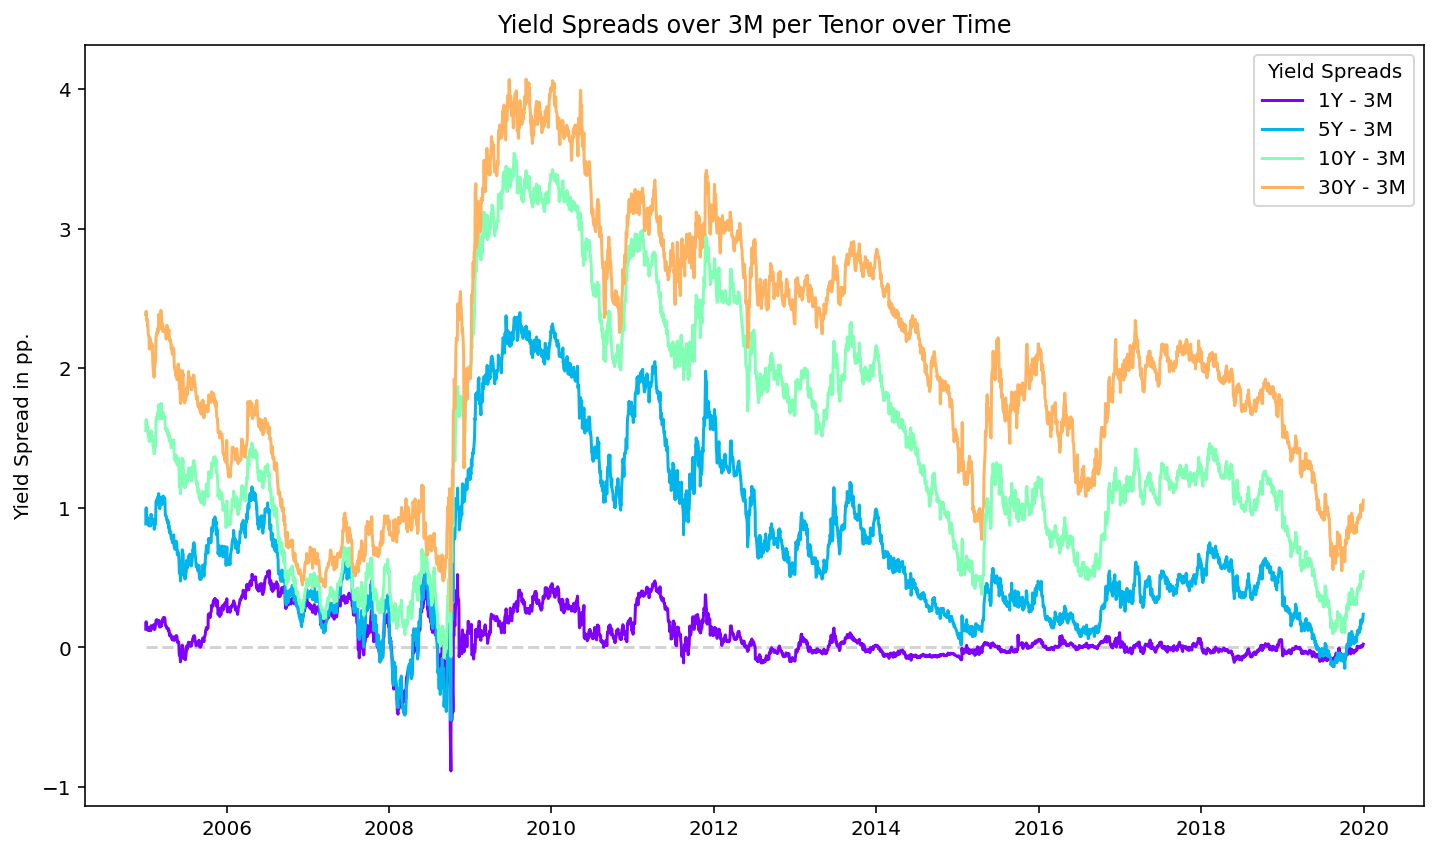

In [21]:
fig = plt.figure(figsize = [12,7])

for i,j in zip(maturities[1:], color):
    plt.plot (spot[i] - spot["3M"], c = j, label = i+" - 3M")

plt.hlines(0, 
           xmin = min(spot.index), 
           xmax = max(spot.index), 
           colors = "lightgrey", 
           linestyles = "dashed", 
           label = "")

plt.title ("Yield Spreads over 3M per Tenor over Time")
plt.ylabel ("Yield Spread in pp.")

plt.legend(title = "Yield Spreads")
plt.show()

#### 6.2 Volatility

In [22]:
roll_window = 30
roll_vola = spot.rolling(roll_window).std().iloc[roll_window-1:]

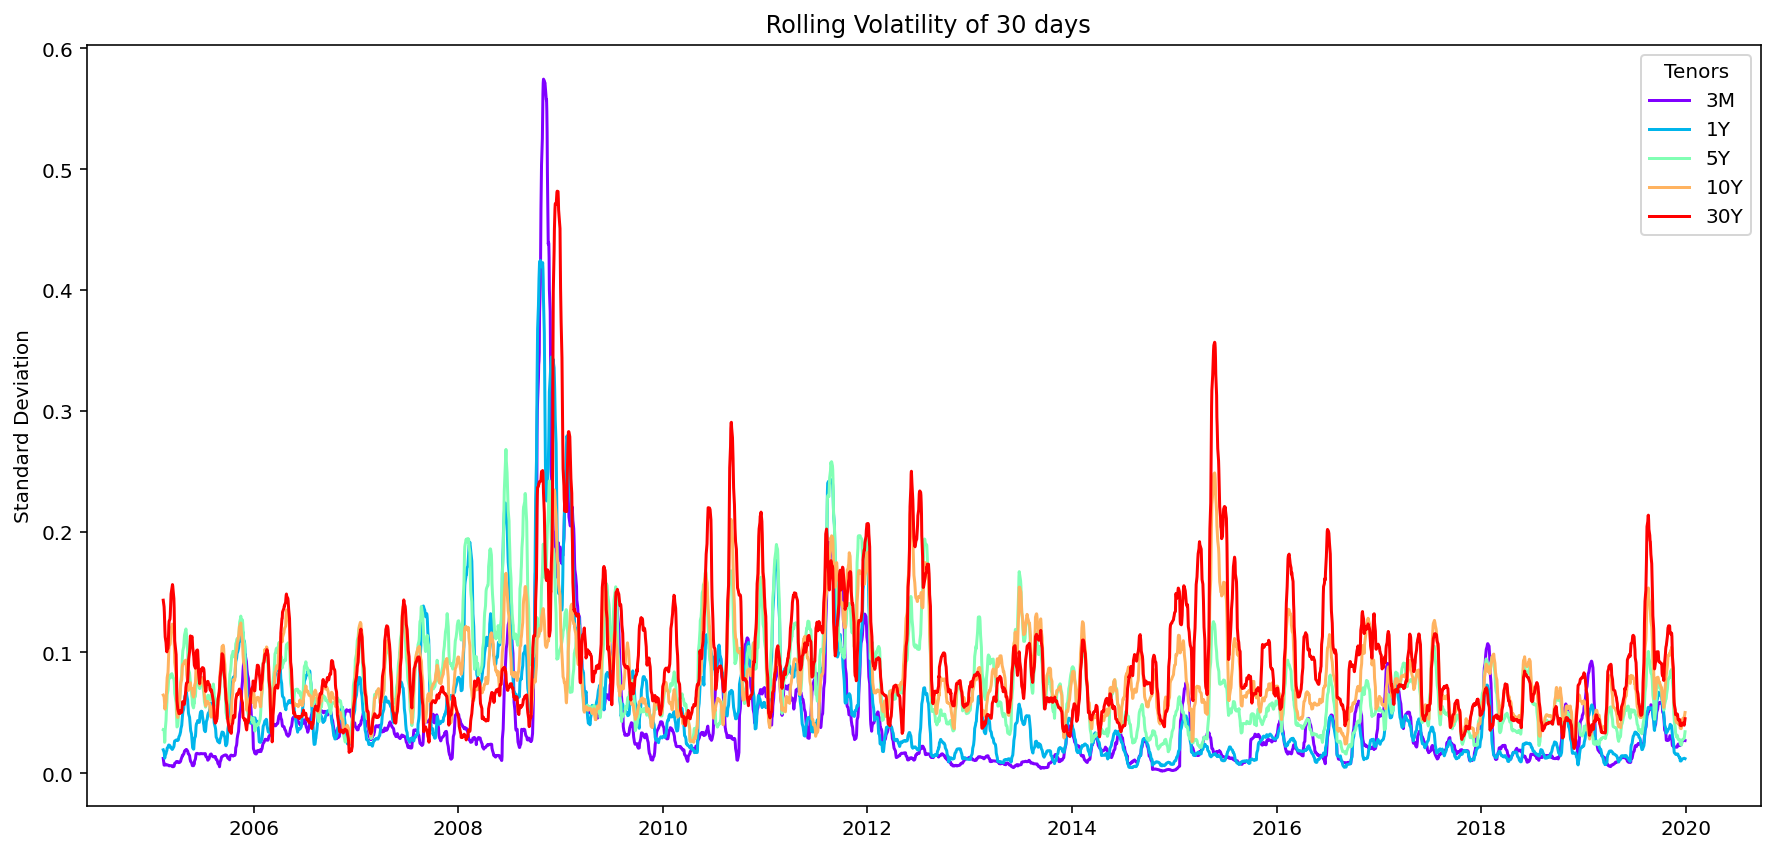

In [23]:
fig = plt.figure(figsize = [15,7])

for i,j in zip(maturities, color):
    plt.plot (roll_vola[i], c = j, label = i)

plt.title (f' Rolling Volatility of {roll_window} {freq}s')
plt.ylabel ("Standard Deviation")
plt.legend(title = "Tenors")

plt.show()

#### 6.3 Correlation

In [24]:
start_dates = ["2010-01-01",
               "2011-01-01",
               "2012-01-01",
               "2013-01-01",
               "2014-01-01",
               "2015-01-01",
               "2016-01-01",
               "2017-01-01",
               "2018-01-01",
               "2019-01-01"]

end_dates = ["2011-01-01",
             "2012-01-01",
             "2013-01-01",
             "2014-01-01",
             "2015-01-01",
             "2016-01-01",
             "2017-01-01",
             "2018-01-01",
             "2019-01-01",
             "2020-01-01"]

In [25]:
def corr_window(start_date, end_date):
    corr_matrix = spot[(spot.index > start_date) & 
                       (spot.index < end_date)].corr()

    corr_matrix.columns.name = None
    corr_matrix = corr_matrix[maturities]
    corr_matrix = corr_matrix.loc[maturities]
    return corr_matrix

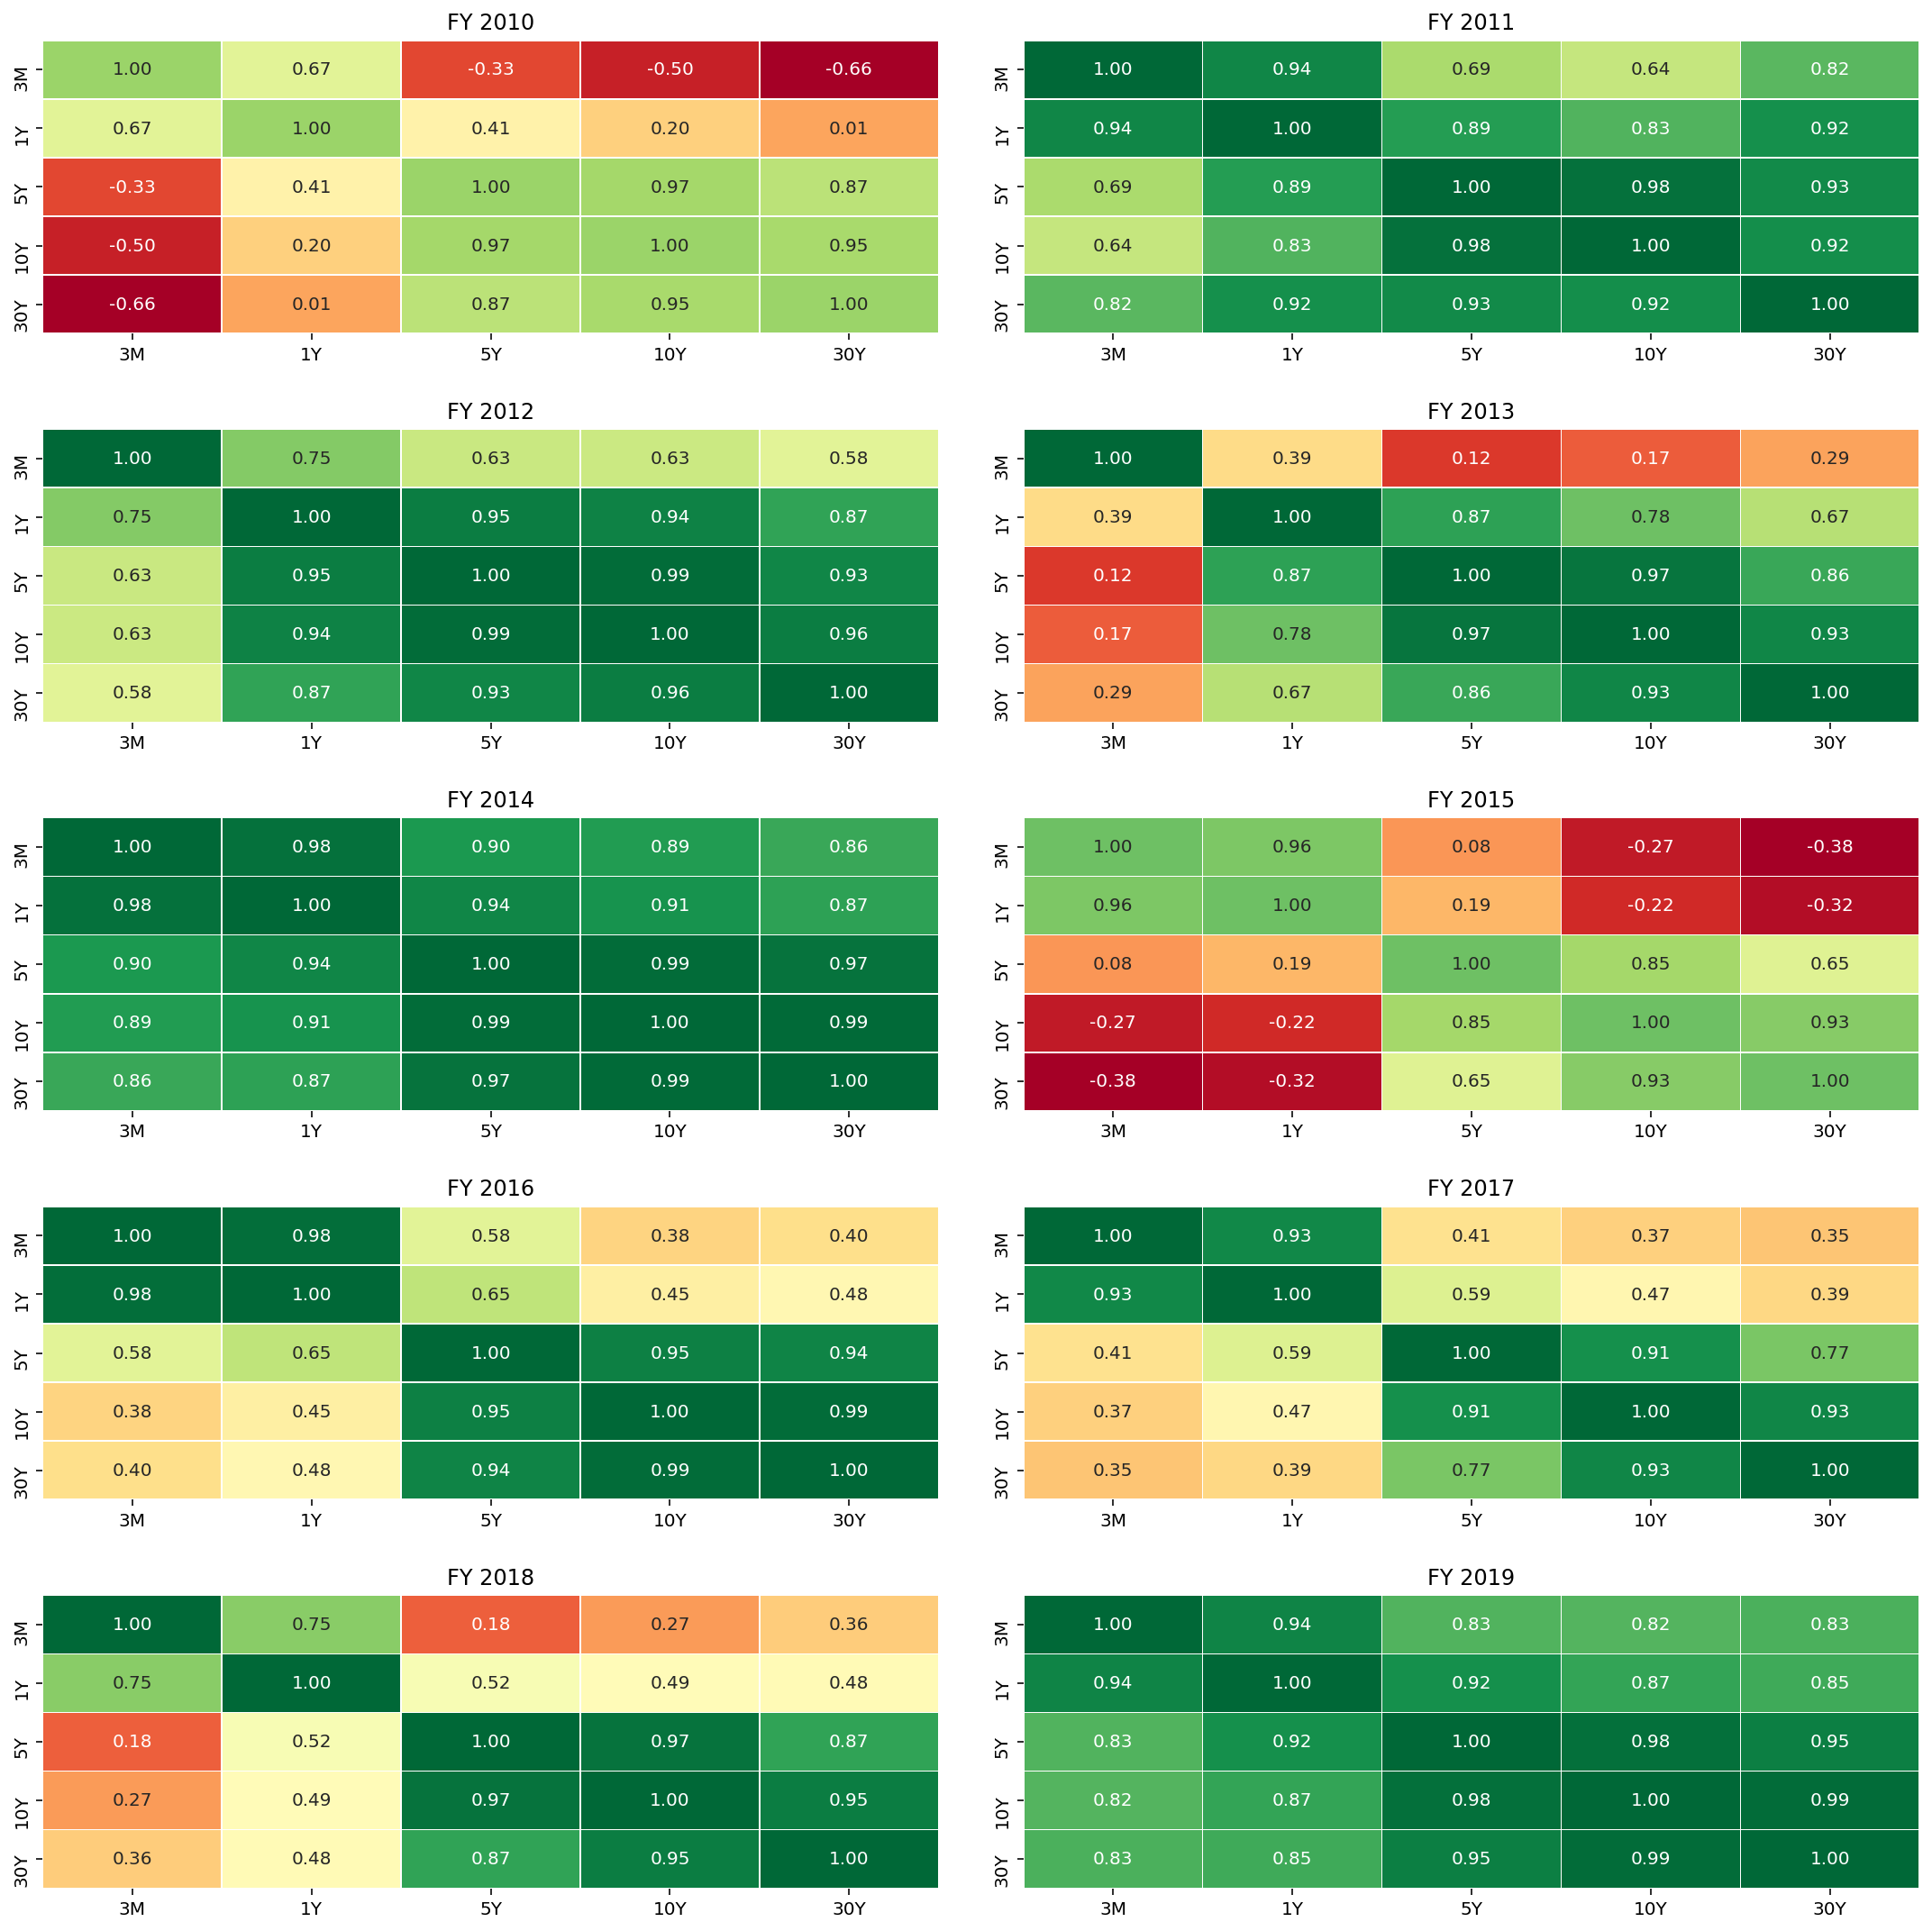

In [26]:
fig, ax = plt.subplots(5, 2, figsize = (15,15))
x = 0

for i in range (5):
    for j in range (2):

        sns.heatmap(corr_window(start_date = start_dates[x], end_date = end_dates[x]), 
                    fmt=".2f", 
                    cmap = "RdYlGn", 
                    linewidth = 0.3, 
                    annot = True,
                    cbar = False,
                    center = 0.5, 
                    ax=ax[i][j])
        
        ax[i][j].title.set_text("FY "+start_dates[x][:4])
        ax[i][j].set(xlabel=None, ylabel=None)
        x += 1

plt.tight_layout(h_pad=2.0, w_pad = 3.0)
plt.show()

#### 6.4 Nelson Siegel

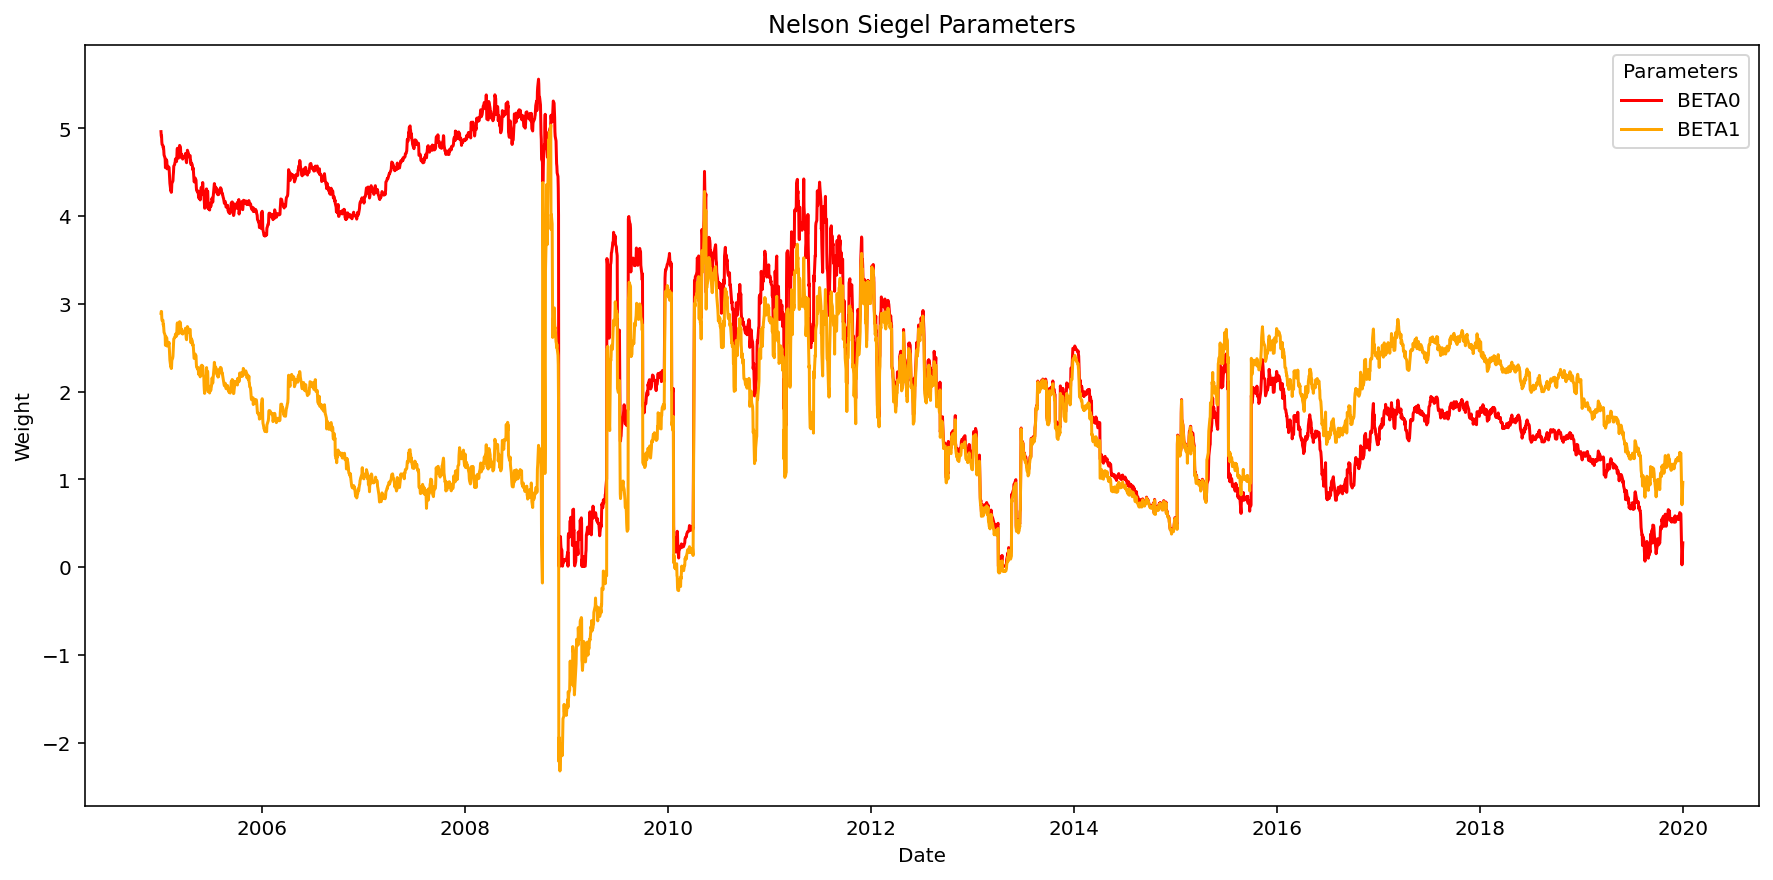

In [27]:
fig = plt.figure(figsize = [15,7])

line_1 = plt.plot (nelson_siegel["BETA0"], c="red", label = "BETA0")
line_2 = plt.plot (nelson_siegel["BETA1"]*-1, c="orange", label = "BETA1")

plt.title ("Nelson Siegel Parameters")
plt.xlabel ("Date")
plt.ylabel ("Weight")

plt.legend(title = "Parameters")
plt.show()

### 7 Extraction
***

In [28]:
spot.to_csv(filepath_out+"spot_"+str(freq)+".csv")
nelson_siegel.to_csv(filepath_out+"nelson_siegel_"+str(freq)+".csv")